In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from tqdm import tqdm
tqdm.pandas()

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [5]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http",
              "https","char","reuters","wall","street","journal","photo","\n"]

In [6]:
domain_extensions = ['.com/','.org/','.net/','.co.uk/']

def url_subpages(url):
    for extension in domain_extensions:
        try:
            if extension in url:
                re_test = re.search(extension,url)
                start_pos = re_test.start()+len(extension)
                cut = url[start_pos:]

                re_test2 = re.search('/',cut)
                end_pos = re_test2.start()
                cut2 = cut[0:end_pos]

                return cut2
            else:
                pass
        except:
            return "no clear section"


In [7]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = text.lower()
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('time magazine','',text)
    text = re.sub('breitbart','',text)
    text = re.sub('click','',text)
    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Read and Clean

In [9]:
#load in data
data = pd.read_csv('initial_data2.csv', index_col = 0)
data.reset_index(drop=True, inplace=True)
data = data.drop_duplicates('url', keep = 'first')
data.drop(['urlToImage'],axis=1,inplace=True)

In [10]:
conditions = [
    (data['content'].isna())
]

choices = [
    (data['description'])
]

data['content'] = np.select(conditions, choices, data['content'])

In [11]:
#drop where description is isna()
to_drop = data[data['description'].isna()].index
data.drop(to_drop, inplace=True)

#drop where title is isna()
to_drop = data[data['title'].isna()].index
data.drop(to_drop, inplace=True)

#drop where target is isna()
to_drop = data[data['target'].isna()].index
data.drop(to_drop, inplace=True)

#drop where publishedAt is isna()
to_drop = data[data['publishedAt'].isna()].index
data.drop(to_drop, inplace=True)

#drop where month is isna()
to_drop = data[data['month'].isna()].index
data.drop(to_drop, inplace=True)

#drop where content is isna()
to_drop = data[data['content'].isna()].index
data.drop(to_drop, inplace=True)

#drop where url is isna()
to_drop = data[data['url'].isna()].index
data.drop(to_drop, inplace=True)

In [12]:
conditions = [
    (data['author'].isna())
]

choices = [
    ('unknown')
]

data['author'] = np.select(conditions, choices, data['author'])

In [13]:
data.drop(['description'],axis=1,inplace=True)

In [14]:
data=data.dropna()

In [15]:
data.isna().sum()

source         0
author         0
title          0
url            0
publishedAt    0
content        0
target         0
month          0
full_text      0
dtype: int64

In [16]:
to_drop = data[data['full_text']=='401 Error'].index
data.drop(to_drop, inplace=True)

In [17]:
data['url_subpages'] = data['url'].apply(url_subpages)

In [18]:
data.url_subpages.value_counts().head(25)

news                10365
no clear section     6805
article              3982
2020                 3125
politics             2140
en_us                2137
homenews             2019
video                1507
intelligencer        1247
Politics             1151
sport                1020
videos                967
health                842
msnbc                 533
states                452
__i                   409
Health                408
US                    371
morning-joe           313
corner                275
articles              272
sports                260
europe                255
clips                 252
entertainment         246
Name: url_subpages, dtype: int64

In [19]:
data[data['url_subpages']=='opinion']

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages
2737,msnbc,Hayes Brown,Trump couldn't let the election be about anyth...,https://www.msnbc.com/opinion/trump-made-sure-...,2020-11-04 11:24:43+00:00,"Progressive policies, the pandemic, the police...",far_left,11.0,"Progressive policies, the pandemic, the police...",opinion
4570,msnbc,Joshua Johnson,America's lack of Covid-19 accountability sugg...,https://www.msnbc.com/opinion/america-s-covid-...,2020-10-14 09:00:11+00:00,America's Covid-19 crisis raises a big questio...,far_left,10.0,America's Covid-19 crisis raises a big questio...,opinion
5058,msnbc,Dr. Kavita Patel,Trump's viral misinformation is spreading fast...,https://www.msnbc.com/opinion/trump-patient-ze...,2020-10-19 19:01:19+00:00,The United States has been caught in the throe...,far_left,10.0,The United States has been caught in the throe...,opinion
13644,bloomberg,unknown,Iceland Is The Perfect Coronavirus Refuge,https://www.bloomberg.com/opinion/articles/202...,2020-05-18 01:11:01+00:00,A nasal swab is a small price to pay to visit ...,left,5.0,Why did this happen?\n\nPlease make sure your ...,opinion
13716,bloomberg,unknown,This New Coronavirus Wave Isn't Like The Old Wave,https://www.bloomberg.com/opinion/articles/202...,2020-07-02 19:23:44+00:00,"Arizona, Florida and Texas aren't facing the s...",left,7.0,Why did this happen?\n\nPlease make sure your ...,opinion
...,...,...,...,...,...,...,...,...,...,...
53179,fox-news,Rear Adm. John Polowczyk,Rear Adm. John Polowczyk: FEMA’s coronavirus r...,https://www.foxnews.com/opinion/rear-adm-john-...,2020-05-06 12:00:46+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,opinion
53180,fox-news,Wall Street Journal Editorial Board,WSJ Editorial Board: Coronavirus crisis -- Why...,https://www.foxnews.com/opinion/coronavirus-ta...,2020-05-05 11:50:38+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,opinion
53219,fox-news,Brian Arbour,Brian Arbour: Coronavirus economy – Trump's re...,https://www.foxnews.com/opinion/coronavirus-ec...,2020-05-12 11:00:15+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,opinion
53452,fox-news,Andy Barr,"Rep. Andy Barr: Coronavirus — Congress, make C...",https://www.foxnews.com/opinion/coronavirus-ch...,2020-04-24 10:00:20+00:00,Get all the latest news on coronavirus and mor...,right,4.0,Get all the latest news on coronavirus and mor...,opinion


In [20]:
data['predictor'] = data['title'] + ' ' + data['full_text']

In [21]:
data['pred_len'] = data['predictor'].progress_apply(len)
data = data[data['pred_len']<9000]

100%|██████████| 49274/49274 [00:00<00:00, 470468.29it/s]


# Feature Engineering

In [22]:
blob = TextBlob((data.predictor[1]))

In [23]:
import textacy

def get_basic_stat(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    basic_stats = {'n_chars': ts.n_chars,
                   'n_long_words':ts.n_long_words ,
                   'n_monosyllable_words': ts.n_monosyllable_words,
                   'n_polysyllable_words': ts.n_polysyllable_words,
                   'n_sents': ts.n_sents,
                   'n_syllables': ts.n_syllables,
                   'n_unique_words': ts.n_unique_words,
                   'n_words': ts.n_words}
    return  basic_stats

In [ ]:
def get_n_long_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_long_words / n_words

In [ ]:
def get_n_monosyllable_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_monosyllable_words / n_words

In [ ]:
def get_n_polysyllable_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_polysyllable_words / n_words

In [ ]:
def get_n_unique_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_unique_words / n_words

In [24]:
tqdm.pandas()
data['Stats'] = data['predictor'].progress_apply(get_basic_stat)

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 46314/46314 [46:43<00:00, 16.52it/s]  


In [25]:
data['n_words'] = data['Stats'].apply(lambda x: x['n_words'])

data['n_long_words'] = data['Stats'].apply(lambda x: x['n_long_words'] / x['n_words'])

data['n_monosyllable_words'] = data['Stats'].apply(lambda x: x['n_monosyllable_words'] / x['n_words'])

data['n_polysyllable_words'] = data['Stats'].apply(lambda x: x['n_polysyllable_words'] / x['n_words'])

data['n_unique_words'] = data['Stats'].apply(lambda x: x['n_unique_words'] / x['n_words'])

In [26]:
data = data[data['n_words']>150]

In [27]:
data.target.value_counts()

left         15327
center        8375
far_left      5080
far_right     3147
right         2333
Name: target, dtype: int64

**Textblob and sentiment**

In [28]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [29]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [30]:
data['polarity'] = data['predictor'].progress_apply(polarity_txt)
data.head(2)

100%|██████████| 34262/34262 [01:57<00:00, 291.61it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity
2,buzzfeed,"[{""@type"":""Person"",""name"":""Hannah Ryan"",""url"":...",Activists Are Using Negative Online Reviews To...,https://www.buzzfeed.com/hannahryan/coronaviru...,2020-04-30 23:20:48+00:00,Abdulla Moradi is one of about 120 people deta...,far_left,4.0,Hotel chains whose facilities have been used f...,hannahryan,Activists Are Using Negative Online Reviews To...,1690,"{'n_chars': 1386, 'n_long_words': 79, 'n_monos...",269,0.293680,0.609665,0.118959,0.572491,0.015668
3,buzzfeed,"[{""@type"":""Person"",""name"":""Gina Rushton"",""url""...","If You’re About To Start Full-Time Work, The C...",https://www.buzzfeed.com/ginarushton/coronavir...,2020-04-29 20:06:42+00:00,Young Australians starting their first job in ...,far_left,4.0,Young Australians starting their first job in ...,ginarushton,"If You’re About To Start Full-Time Work, The C...",2434,"{'n_chars': 1938, 'n_long_words': 79, 'n_monos...",431,0.183295,0.735499,0.085847,0.531323,-0.020759


In [31]:
data['subjectivity'] = data['predictor'].progress_apply(subj_txt)
data.head(2)

100%|██████████| 34262/34262 [02:25<00:00, 235.67it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
2,buzzfeed,"[{""@type"":""Person"",""name"":""Hannah Ryan"",""url"":...",Activists Are Using Negative Online Reviews To...,https://www.buzzfeed.com/hannahryan/coronaviru...,2020-04-30 23:20:48+00:00,Abdulla Moradi is one of about 120 people deta...,far_left,4.0,Hotel chains whose facilities have been used f...,hannahryan,Activists Are Using Negative Online Reviews To...,1690,"{'n_chars': 1386, 'n_long_words': 79, 'n_monos...",269,0.293680,0.609665,0.118959,0.572491,0.015668,0.355131
3,buzzfeed,"[{""@type"":""Person"",""name"":""Gina Rushton"",""url""...","If You’re About To Start Full-Time Work, The C...",https://www.buzzfeed.com/ginarushton/coronavir...,2020-04-29 20:06:42+00:00,Young Australians starting their first job in ...,far_left,4.0,Young Australians starting their first job in ...,ginarushton,"If You’re About To Start Full-Time Work, The C...",2434,"{'n_chars': 1938, 'n_long_words': 79, 'n_monos...",431,0.183295,0.735499,0.085847,0.531323,-0.020759,0.294318


In [32]:
import seaborn as sns

In [33]:
data.target.value_counts()

left         15327
center        8375
far_left      5080
far_right     3147
right         2333
Name: target, dtype: int64

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

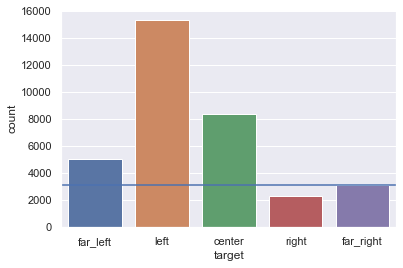

In [35]:
graph = sns.countplot(x='target', data=data)
graph.axhline(3147)

# Test Dummy

In [36]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
X = data['predictor']
y = data['target']

dummy_cf = DummyClassifier(strategy='stratified')
dummy_cf.fit(X,y)
y_preds = dummy_cf.predict(X)

accuracy = dummy_cf.score(X,y)


In [37]:
results = pd.DataFrame(columns = ['model','accuracy'])
new_row = {'model': 'Dummy', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.293532


# Resample

In [38]:
from sklearn.utils import resample
far_right = data[data.target == 'far_right'] #resample target
right = data[data.target == 'right'] #upsample
center = data[data.target == 'center'] #downsample
left = data[data.target =='left'] #downsample
far_left = data[data.target == 'far_left'] #downsample

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

center_downsampled = resample(center,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

left_downsampled = resample(left,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

far_left_downsampled = resample(far_left,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

data = pd.concat([far_right, right_upsampled, center_downsampled,left_downsampled,far_left_downsampled])
data.target.value_counts()

far_left     3147
far_right    3147
left         3147
right        3147
center       3147
Name: target, dtype: int64

In [39]:
data.reset_index(drop=True,inplace=True)
data.head()

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
0,breitbart-news,Gabrielle Reyes,Xi Honors Doc Who Suggested Foreign Coronaviru...,https://www.breitbart.com/asia/2020/09/08/chin...,2020-09-09 17:19:38+00:00,Chinese dictator Xi Jinping on Tuesday present...,far_right,9.0,Chinese dictator Xi Jinping on Tuesday present...,asia,Xi Honors Doc Who Suggested Foreign Coronaviru...,3610,"{'n_chars': 2974, 'n_long_words': 201, 'n_mono...",542,0.370849,0.560886,0.190037,0.525830,0.050492,0.303881
1,breitbart-news,Frances Martel,China Prepares to Fight Coronavirus Lawsuits -...,https://www.breitbart.com/asia/2020/05/27/chin...,2020-05-27 16:49:38+00:00,"China’s National People’s Congress (NPC), one ...",far_right,5.0,"China’s National People’s Congress (NPC), one ...",asia,China Prepares to Fight Coronavirus Lawsuits -...,5646,"{'n_chars': 4646, 'n_long_words': 292, 'n_mono...",875,0.333714,0.587429,0.181714,0.412571,0.010437,0.236853
2,breitbart-news,"Thomas D. Williams, Ph.D.",Pope Calls on All Religions to Join in Prayer...,https://www.breitbart.com/health/2020/05/14/po...,2020-05-14 16:07:37+00:00,ROME Pope Francis has asked people of all reli...,far_right,5.0,ROME — Pope Francis has asked people of all re...,health,Pope Calls on All Religions to Join in Prayer....,2430,"{'n_chars': 1940, 'n_long_words': 103, 'n_mono...",407,0.253071,0.687961,0.135135,0.501229,0.149667,0.429667
3,breitbart-news,John Hayward,Report: China Quietly Keeping Residences Quara...,https://www.breitbart.com/national-security/20...,2020-04-16 16:40:37+00:00,A report at the Epoch Times on Tuesday said th...,far_right,4.0,A report at the Epoch Times on Tuesday said th...,national-security,Report: China Quietly Keeping Residences Quara...,3843,"{'n_chars': 3147, 'n_long_words': 167, 'n_mono...",620,0.269355,0.658065,0.143548,0.524194,0.076444,0.404345
4,breitbart-news,Simon Kent,"Shoot Stray Dogs, Win Cash Prizes: How Chinese...",https://www.breitbart.com/asia/2020/03/16/shoo...,2020-03-16 14:49:40+00:00,A southern China community neighbourhood manag...,far_right,3.0,A southern China community neighbourhood manag...,asia,"Shoot Stray Dogs, Win Cash Prizes: How Chinese...",2754,"{'n_chars': 2225, 'n_long_words': 121, 'n_mono...",454,0.266520,0.640969,0.129956,0.579295,0.054308,0.372161


# Test out LDA

In [40]:
import gensim

In [41]:
lda_far_right = data[data['target']=='far_right']['predictor']
lda_right = data[data['target']=='right']['predictor']
lda_center = data[data['target']=='right']['predictor']
lda_left = data[data['target']=='right']['predictor']
lda_far_left = data[data['target']=='far_left']['predictor']
all_sides = data['predictor']

In [42]:
lda_far_right_token = lda_far_right.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_far_right_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_far_right_token]

far_right_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

far_right_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:20<00:00, 156.86it/s]


[(0,
  '0.014*"coronavirus" + 0.010*"china" + 0.006*"chinese" + 0.006*"state" + 0.005*"percent" + 0.005*"government" + 0.005*"report" + 0.005*"people" + 0.004*"would" + 0.004*"pandemic"'),
 (1,
  '0.013*"trump" + 0.011*"coronavirus" + 0.010*"president" + 0.008*"people" + 0.006*"biden" + 0.005*"time" + 0.005*"would" + 0.005*"make" + 0.004*"know" + 0.004*"pandemic"'),
 (2,
  '0.015*"coronavirus" + 0.011*"state" + 0.009*"test" + 0.007*"case" + 0.006*"people" + 0.006*"report" + 0.006*"health" + 0.005*"virus" + 0.005*"covid" + 0.004*"trump"')]

Topic 1: Trump, Corona, Police

Topic 2: Coronavirus and China

Topic 3: Coronavirus and Masks

In [43]:
lda_right_token = lda_right.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_right_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_right_token]

right_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

right_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:21<00:00, 145.12it/s]


[(0,
  '0.014*"coronavirus" + 0.009*"covid" + 0.008*"trump" + 0.007*"virus" + 0.006*"president" + 0.006*"news" + 0.005*"people" + 0.005*"study" + 0.005*"health" + 0.004*"report"'),
 (1,
  '0.011*"coronavirus" + 0.006*"people" + 0.005*"time" + 0.004*"state" + 0.004*"news" + 0.004*"pandemic" + 0.004*"would" + 0.004*"also" + 0.004*"vote" + 0.003*"like"'),
 (2,
  '0.016*"coronavirus" + 0.009*"trump" + 0.009*"state" + 0.007*"people" + 0.007*"news" + 0.007*"test" + 0.006*"case" + 0.006*"health" + 0.006*"covid" + 0.006*"report"')]

Topic 1: Covid testing/reporting

Topic 2: Coronavirus and opening schools

Topic 3: Trump, Biden, and Covid responses

In [44]:
lda_center_token = lda_center.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_center_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_center_token]

center_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

center_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:17<00:00, 182.49it/s]


[(0,
  '0.021*"coronavirus" + 0.011*"covid" + 0.009*"case" + 0.009*"report" + 0.008*"health" + 0.008*"virus" + 0.007*"test" + 0.007*"state" + 0.007*"news" + 0.006*"study"'),
 (1,
  '0.009*"coronavirus" + 0.006*"state" + 0.006*"people" + 0.004*"time" + 0.004*"would" + 0.004*"pandemic" + 0.004*"make" + 0.004*"trump" + 0.004*"news" + 0.003*"even"'),
 (2,
  '0.017*"trump" + 0.014*"coronavirus" + 0.011*"president" + 0.007*"test" + 0.007*"biden" + 0.007*"news" + 0.007*"people" + 0.006*"state" + 0.005*"covid" + 0.005*"time"')]

Topic 1: Trumps and China coronavirus

Topic 2: Covid Testing

Topic 3: Covid and School

In [45]:
lda_left_token = lda_left.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_left_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_left_token]

left_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

left_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:17<00:00, 179.57it/s]


[(0,
  '0.014*"trump" + 0.012*"coronavirus" + 0.010*"president" + 0.007*"people" + 0.006*"biden" + 0.006*"news" + 0.006*"state" + 0.005*"test" + 0.005*"time" + 0.005*"covid"'),
 (1,
  '0.018*"coronavirus" + 0.009*"case" + 0.008*"covid" + 0.007*"health" + 0.007*"report" + 0.007*"virus" + 0.007*"people" + 0.006*"state" + 0.006*"test" + 0.006*"news"'),
 (2,
  '0.013*"coronavirus" + 0.006*"state" + 0.006*"covid" + 0.005*"news" + 0.004*"time" + 0.004*"trump" + 0.004*"health" + 0.004*"would" + 0.004*"house" + 0.004*"also"')]

Topic 1: Covid testing

Topic 2: Coronavirus research and vaccines

Topic 3: Covid cases under trump

In [46]:
lda_far_left_token = lda_far_left.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_far_left_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_far_left_token]

far_left_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

far_left_lda.show_topics(formatted=True)

100%|██████████| 3147/3147 [00:53<00:00, 58.43it/s]


[(0,
  '0.006*"make" + 0.005*"coronavirus" + 0.005*"like" + 0.005*"time" + 0.004*"people" + 0.004*"twitter" + 0.004*"also" + 0.003*"mask" + 0.003*"work" + 0.003*"pandemic"'),
 (1,
  '0.010*"people" + 0.007*"coronavirus" + 0.006*"like" + 0.006*"time" + 0.006*"work" + 0.005*"also" + 0.005*"make" + 0.004*"take" + 0.004*"pandemic" + 0.004*"company"'),
 (2,
  '0.013*"trump" + 0.009*"coronavirus" + 0.008*"state" + 0.007*"people" + 0.005*"president" + 0.005*"covid" + 0.005*"would" + 0.004*"health" + 0.004*"case" + 0.004*"time"')]

Topic 1: Working in Covid

Topic 2: Trump and Coronavirus

Topic 3:Working in Covid

In [47]:
all_token = all_sides.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(all_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in all_token]

all_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

all_lda.show_topics(formatted=True)

100%|██████████| 15735/15735 [01:44<00:00, 150.09it/s]


[(0,
  '0.009*"people" + 0.007*"like" + 0.006*"police" + 0.006*"time" + 0.006*"coronavirus" + 0.005*"live" + 0.005*"make" + 0.004*"take" + 0.004*"black" + 0.004*"think"'),
 (1,
  '0.014*"coronavirus" + 0.012*"china" + 0.009*"government" + 0.006*"chinese" + 0.006*"country" + 0.006*"world" + 0.006*"report" + 0.005*"minister" + 0.005*"case" + 0.005*"countries"'),
 (2,
  '0.046*"trump" + 0.022*"president" + 0.012*"coronavirus" + 0.010*"house" + 0.009*"white" + 0.008*"biden" + 0.007*"test" + 0.006*"campaign" + 0.006*"would" + 0.005*"news"'),
 (3,
  '0.008*"coronavirus" + 0.006*"workers" + 0.006*"company" + 0.006*"would" + 0.006*"bill" + 0.005*"pandemic" + 0.005*"economic" + 0.005*"fund" + 0.005*"work" + 0.005*"state"'),
 (4,
  '0.020*"vote" + 0.014*"state" + 0.014*"election" + 0.011*"voters" + 0.010*"poll" + 0.010*"biden" + 0.009*"ballot" + 0.009*"mail" + 0.008*"percent" + 0.006*"trump"'),
 (5,
  '0.009*"people" + 0.008*"like" + 0.008*"time" + 0.007*"work" + 0.007*"make" + 0.005*"also" + 0.

Topic 1: Presidential Election and COVID

Topic 2: Positive Cases as Schools

Topic 3: Mask Wearing, Protests

Topic 4: Covid and Entertainment

Topic 5: Trump Makes Announcement at WH

Topic 6: Covid and Economy

Topic 7: Covid and China

Topic 8: Covid Testing

In [48]:
dominant_topics = []

for i in data.index:
    row_list = all_lda[bow_corpus][i]
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic = row[0][0]
    dominant_topics.append(topic)
    

In [49]:
data['dominant_topic'] = pd.Series(dominant_topics)

In [50]:
data[data['dominant_topic']==3].predictor

16       Nancy Pelosi, Chuck Schumer: GOP Coronavirus A...
19       Report: Coronavirus May Permanently Replace Hu...
20       Nolte: Biden Family Corruption Spreads Into Co...
43       House Democrats Block Funding for Police, Smal...
53       Fact Check: Democrats' HEROES Act Is Bailout o...
                               ...                        
15704    Leisure Travelers Will Miss Business Travelers...
15707    GOP in Disarray as House Nears Vote on Coronav...
15729    Trump Says Coronavirus Will Help the Economy b...
15730    Trump’s Stimulus Orders Create Legal and Admin...
15731    Millions In ‘Small Business’ Coronavirus Bailo...
Name: predictor, Length: 2007, dtype: object

In [51]:
sentences = []
test = 'this should be. exactly one period. per sentence please.'
test_split = test.split(" ")
length = len(test_split)
group_size = 3

i = 0

while i < length:
    values = []
    for word in test_split[i:i+group_size]:
        values.append(word)
    
    sentence_counter = 0
    for word in values:
        if '.' in word:
            sentence_counter += 1
    sentences.append(sentence_counter)
    i = i + group_size
        
print(sum(sentences)/len(sentences))

1.0


In [52]:
def mean_sentences_per_100(text, group_size):
    sentences = []
    text_split = text.split(" ")
    length = len(text_split)

    i = 0

    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(word)

        sentence_counter = 0
        for word in values:
            if '.' in word:
                sentence_counter += 1
        sentences.append(sentence_counter)
        i = i + group_size

    return sum(sentences)/len(sentences)

In [53]:
def mean_character_per_100(text, group_size):
    averages = []
    
    text_split = text.split(" ")
    length = len(text_split)
    i = 0
    
    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(len(word))
        if len(values)==group_size:
            averages.append(sum(values)/len(values))
        else:
            pass
        i = i + group_size
    

    return sum(averages)/len(averages)

        

In [54]:
# Coleman-Liau Index
# mccphw: mean character count per hundred words
# mscphw: mean sentence count per hundred words
def cli(text, group_size):
    mccphw = mean_character_per_100(text, group_size)
    mscphw = mean_sentences_per_100(text, group_size)
    
    return (0.0588 * mccphw) - (0.296 * mscphw) - 15.8

In [55]:
data['coleman_index'] = data['predictor'].progress_apply(lambda x: cli(x,100))

100%|██████████| 15735/15735 [00:03<00:00, 4841.26it/s]


In [56]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
scaler = MinMaxScaler()
data[['polarity','coleman_index']] = scaler.fit_transform(data[['polarity','coleman_index']])

In [59]:
pickle_out = open('normalizer.pickle', 'wb')
pickle.dump(scaler, pickle_out)
pickle_out.close()

In [58]:
import pickle
# Save
with open('normalizer.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [177]:
data.to_csv('clean_data2.csv')

**Topic by target**

Topic 1: Presidential Election and COVID

Topic 2: Positive Cases as Schools

Topic 3: Mask Wearing, Protests

Topic 4: Covid and Jobs

Topic 5: Trump Makes Announcement at WH

Topic 6: Covid and Economy

Topic 7: Covid and China

Topic 8: Covid Testing

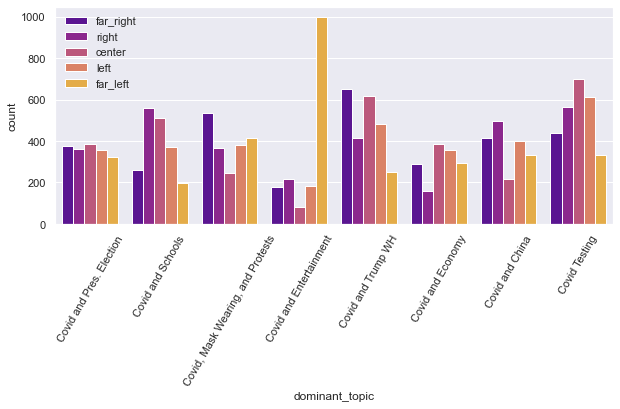

In [192]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x='dominant_topic', hue='target',data=data,palette='plasma')
ax.set_xticklabels(['Covid and Pres. Election',
                    'Covid and Schools',
                   'Covid, Mask Wearing, and Protests',
                   'Covid and Entertainment',
                   'Covid and Trump WH',
                   'Covid and Economy',
                   'Covid and China',
                   'Covid Testing'])

ax.legend(loc='upper left', frameon=False)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/topic_by_target.png')

plt.show()

# EDA

In [193]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 1min 27s, sys: 345 ms, total: 1min 28s
Wall time: 1min 28s


TfidfVectorizer(preprocessor=<function clean_txt at 0x1491e8280>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [194]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in ['far_left','left','center','right','far_right']:
    print("Top 20 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(20)
    print(df_right)
    print("###############")
    if cat != 'far_left':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 20 terms for:  far_left
          Terms   far_left
0        people  72.219456
1          like  70.370161
2   coronavirus  67.097521
3          time  63.688881
4          make  63.300783
5         trump  58.427164
6          also  57.271413
7          even  55.915124
8          work  55.446866
9      pandemic  54.878627
10         take  52.983563
11        covid  52.917445
12        would  52.671420
13        state  48.375406
14         tell  48.258976
15         many  47.653769
16      company  47.515182
17         home  47.050951
18         want  45.022677
19         call  43.725502
###############
(20, 2)
Top 20 terms for:  left
          Terms       left
0   coronavirus  87.072223
1         trump  75.121526
2        people  71.778924
3         covid  71.593016
4          test  69.460617
5         state  68.096180
6          case  67.188974
7        health  66.092580
8         virus  61.759321
9     president  60.513776
10         also  60.028233
11     pandemic  58.662881
12    

In [195]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

(44, 5)

In [196]:
import numpy as np
from textacy.viz.termite import draw_termite_plot

In [197]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())

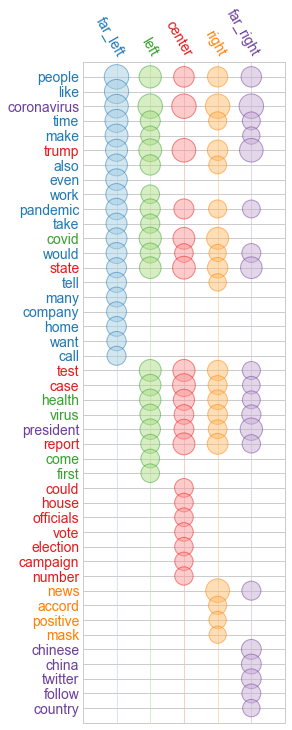

In [198]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2,3,4])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/termite_plot.png')

**Polarity by target**

In [199]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

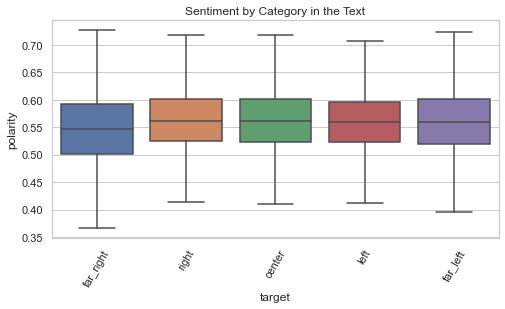

In [201]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="target", y="polarity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_by_target.png')

**Polarity over time**

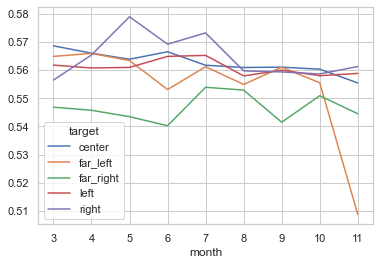

In [202]:
data.groupby(by=['month','target'])['polarity'].mean().unstack().plot()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_time.png')

**Subjectivity by target**

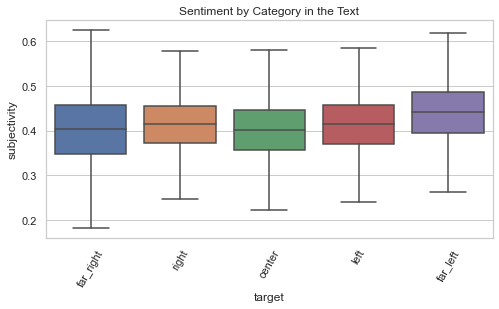

In [204]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="target", y="subjectivity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_by_target.png')

**Subjectivity over time**

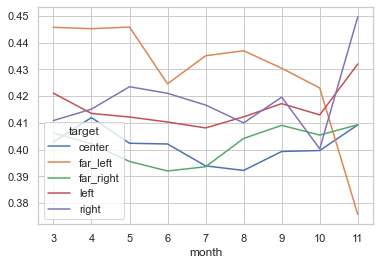

In [205]:
data.groupby(by=['month','target'])['subjectivity'].mean().unstack().plot()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_time.png')

**n_long_words by target**

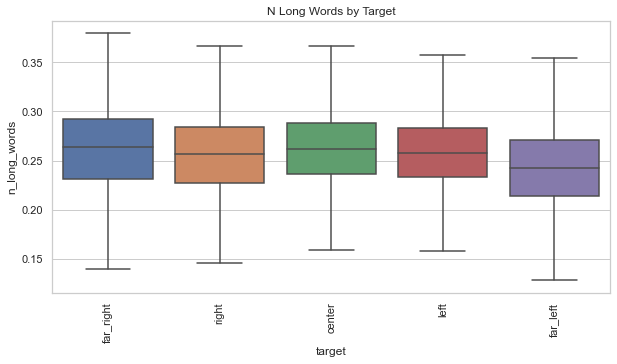

In [218]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_long_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Long Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/longwords_target.png')

**n_monosyllable_words by target**

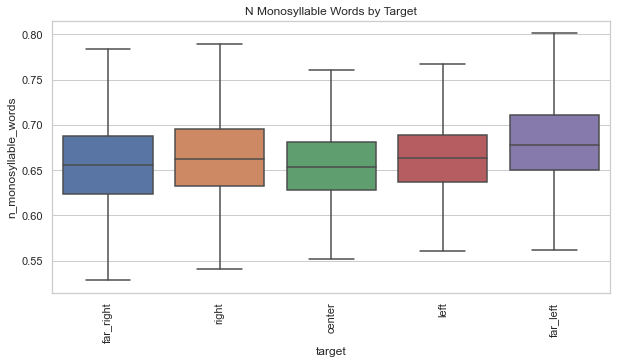

In [217]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_monosyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Monosyllable Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mono_target.png')

**n_polysyllable_words by target**

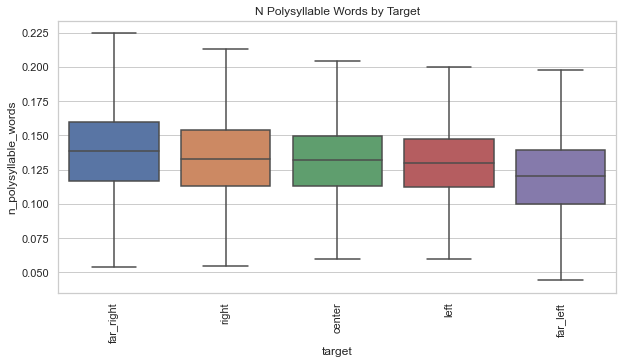

In [216]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_polysyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Polysyllable Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/poly_target.png')

**n_unique_words by target**

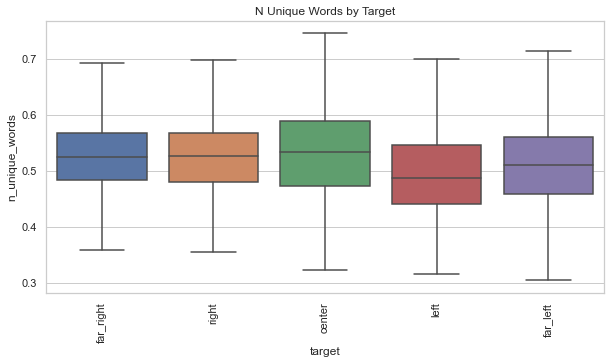

In [215]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_unique_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Unique Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/unique_target.png')

**coleman_index by target**

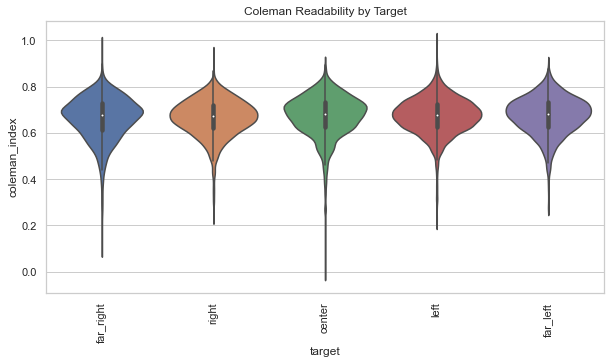

In [214]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="coleman_index", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Coleman Readability by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/unique_target.png')